In [17]:
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle
import os
import string

import torch
import torch.nn as nn
import joblib

In [18]:
class MonteCarloDropout(nn.Dropout):
    def forward(self, input):
        return nn.functional.dropout(input, self.p, True, self.inplace)

class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_size, 2056),
            nn.ReLU(),
            #MonteCarloDropout(0.2),
            nn.Linear(2056, 1024),
            nn.ReLU(),
            #MonteCarloDropout(0.2), 
	        nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            MonteCarloDropout(0.2), 
            nn.Linear(128, 1),
        )

    def forward(self, x):
        return self.layers(x)

In [19]:
mid = "10pct_512"
path = "/home/sachin/Documents/NIPR/Research/Data/ML/MLP"

In [20]:
model = MLP(10)
model.load_state_dict(torch.load(f'{path}/{mid}_model.pt'))
model.eval()

MLP(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=2056, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2056, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): ReLU()
    (10): MonteCarloDropout(p=0.2, inplace=False)
    (11): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [21]:
y_df = pd.read_csv(f'{path}/{mid}_y_df.csv')
y_test = y_df.pop('y_test')
y_pred = y_df.pop('y_pred')

with open(f'{path}/{mid}_scaler.pkl', 'rb') as f:
    scaler = joblib.load(f)

col_names = y_df.columns.to_list()
norm_arr = scaler.inverse_transform(y_df)
y_df = pd.DataFrame(norm_arr, columns=col_names)
y_df['y_test'] = y_test
y_df['y_pred'] = y_pred
y_df['y_diff'] = y_df['y_pred'] - y_df['y_test']
y_df

,mlt,lon,lat,BY_GSE,BZ_GSE,flow_speed,proton_density,tilt_angle,mlt_sin,mlt_cos,lon_sin,lon_cos,y_test,y_pred,y_diff
0,21.879325,328.189873,55.517241,-0.37,-0.37,424.0,3.45,-0.244044,-0.527106,0.849800,-0.541857,0.840471,4.745818,2.971149,-1.774668
1,22.788186,341.822785,67.931034,4.08,-2.85,523.0,2.33,-0.444959,-0.311957,0.950096,-0.328491,0.944507,-2.009163,-0.154949,1.854214
2,17.940928,269.113924,74.827586,-10.11,-9.48,398.0,9.23,-0.267498,-0.999880,-0.015464,-0.999458,-0.032912,22.131792,11.433074,-10.698718
3,6.125738,91.886076,58.275862,2.13,0.28,424.0,3.81,-0.542234,0.999458,-0.032912,0.999880,-0.015464,-2.825071,-2.019200,0.805871
4,5.216878,78.253165,76.206897,1.18,1.34,526.0,4.16,-0.409327,0.979057,0.203588,0.975355,0.220644,-3.555985,-2.839349,0.716636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109896,23.091139,346.367089,59.655172,1.79,4.78,566.0,2.22,0.272575,-0.235700,0.971826,-0.252625,0.967564,0.350139,2.699103,2.348963
109897,22.788186,341.822785,67.931034,-1.27,2.64,363.0,5.20,0.484620,-0.311957,0.950096,-0.328491,0.944507,4.029456,1.323230,-2.706225
109898,1.884388,28.265823,83.103448,2.27,-0.15,365.0,2.89,0.153010,0.473563,0.880760,0.458119,0.888891,-2.772669,4.578951,7.351620
109899,6.731646,100.974684,83.103448,-1.86,-1.26,584.0,1.40,-0.327048,0.981711,-0.190375,0.984884,-0.173213,7.192841,-18.499287,-25.692128


In [22]:
mae = np.mean(np.abs(y_df['y_diff']))
rmse = np.sqrt(np.mean(y_df['y_diff'] ** 2))
R = np.corrcoef(y_df['y_pred'], y_df['y_test'])[0, 1]
err_pct = np.mean((y_df['y_pred'] - y_df['y_test']) / y_df['y_test'] * 100)

print(f"MAE: {mae:.2f} [kV]")
print(f"RMSE: {rmse:.2f} [kV]")
print(f"Mean Abs Err pct: {err_pct:.1f}%")
print(f"Correlation: {R:.2f}")

MAE: 2.58 [kV]
RMSE: 4.18 [kV]
Mean Abs Err pct: -34.5%
Correlation: 0.93


In [23]:
y_df['lon'] = y_df['lon'].round()
y_df['lat'] = y_df['lat'].round()
y_df = y_df.set_index(['lat', 'lon']) 
y_df = y_df.groupby(['lat', 'lon']).mean()
y_ds = y_df.to_xarray()
y_ds

<xarray.Dataset> Size: 250kB
Dimensions:         (lat: 30, lon: 80)
Coordinates:
  * lat             (lat) float64 240B 50.0 51.0 53.0 54.0 ... 87.0 89.0 90.0
  * lon             (lon) float64 640B 1.0 6.0 10.0 15.0 ... 351.0 355.0 360.0
Data variables: (12/13)
    mlt             (lat, lon) float64 19kB 0.06667 0.3696 0.6726 ... 23.7 0.0
    BY_GSE          (lat, lon) float64 19kB -0.4622 -1.036 ... -0.7023 -0.5047
    BZ_GSE          (lat, lon) float64 19kB 0.5488 0.6302 ... -0.174 -0.09408
    flow_speed      (lat, lon) float64 19kB 428.1 414.2 458.0 ... 434.2 425.8
    proton_density  (lat, lon) float64 19kB 7.489 6.545 6.655 ... 6.771 6.721
    tilt_angle      (lat, lon) float64 19kB 0.03884 0.01534 ... -0.005476
    ...              ...
    mlt_cos         (lat, lon) float64 19kB 0.9998 0.9953 0.9845 ... 0.9969 1.0
    lon_sin         (lat, lon) float64 19kB 0.0 0.07923 ... -0.09662 -0.01745
    lon_cos         (lat, lon) float64 19kB 1.0 0.9969 0.9874 ... 0.9953 0.9998
    y_test          (lat, lon) float64 19kB 1.436 0.8329 ... -2.811 -0.3892
    y_pred          (lat, lon) float64 19kB 1.754 0.9482 1.678 ... -4.257 -1.38
    y_diff          (lat, lon) float64 19kB 0.3176 0.1153 ... -1.446 -0.9904

NameError: name 'rqqwrwqr' is not defined

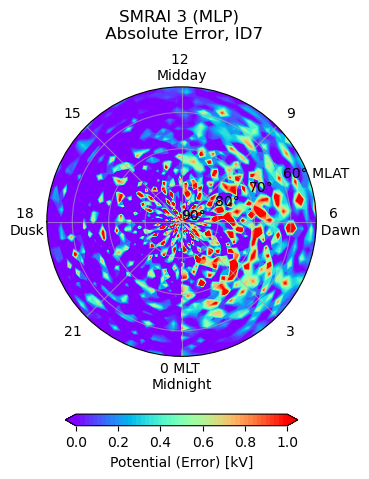

In [24]:
# Define the polar plot parameters
theta = np.linspace(0, 360, 80) - 90
theta_rad = theta / 360 * 2 * np.pi
r = 90 - np.linspace(53.1, 89.7, 30)
shrink = .5

abs_error = (y_ds['y_diff'].values)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6,5))

c_true = ax.contourf(theta_rad, r, abs_error, levels=np.linspace(0, 1, 50), cmap='rainbow', extend='both')
ax.set_ylim([0, 37])
ax.set_yticks([0, 10, 20, 30])
ax.set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
ax.set_xlim([-np.pi, np.pi])
ax.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
ax.set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n  Dawn", "9", "12 \nMidday", "15", "18 \nDusk"])
ax.set_title(f'SMRAI 3 (MLP) \n Absolute Error, ID7', pad=10, fontsize=12)
plt.colorbar(c_true, ax=ax, label='Potential (Error) [kV]', shrink=shrink, pad=0.15, ticks=np.arange(0,1.1,0.2), orientation='horizontal')
ax.grid(True, linestyle='-', alpha=0.6)

#plt.savefig('MLP_potential_ID7.png', dpi=300, bbox_inches='tight')